In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
import mediapipe as mp
import numpy as np
import cv2
import math

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False)

# Define landmark indices for coordinates (22 key points)
KEYPOINTS = [
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER,
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ELBOW,
    mp_pose.PoseLandmark.RIGHT_ELBOW,
    mp_pose.PoseLandmark.LEFT_WRIST,
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_HEEL,
    mp_pose.PoseLandmark.RIGHT_HEEL,
    mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
    mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
    mp_pose.PoseLandmark.LEFT_PINKY,
    mp_pose.PoseLandmark.RIGHT_PINKY,
    mp_pose.PoseLandmark.LEFT_INDEX,
    mp_pose.PoseLandmark.RIGHT_INDEX,
    mp_pose.PoseLandmark.RIGHT_THUMB,
    mp_pose.PoseLandmark.LEFT_THUMB
]

# Define angle triplets (shoulders, hips, elbows, knees, etc.)
ANGLE_TRIPLETS = [
    (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
    (mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW),
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST),
    (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST),
    (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
    (mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE),
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE),
    (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE),
    (mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_HEEL),
    (mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_HEEL),
    (mp_pose.PoseLandmark.LEFT_ANKLE, mp_pose.PoseLandmark.LEFT_HEEL, mp_pose.PoseLandmark.LEFT_FOOT_INDEX),
    (mp_pose.PoseLandmark.RIGHT_ANKLE, mp_pose.PoseLandmark.RIGHT_HEEL, mp_pose.PoseLandmark.RIGHT_FOOT_INDEX)
]

def calculate_angle(a, b, c):
    """Compute angle between three landmarks."""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

def extract_features_from_frame(frame):
    """Extract 78 features: 66 coordinates + 12 angles from a video frame."""
    results = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
        return None  # Could not detect body

    landmarks = results.pose_landmarks.landmark
    coords = []
    for kp in KEYPOINTS:
        x, y, z = landmarks[kp.value].x, landmarks[kp.value].y, landmarks[kp.value].z
        coords.extend([x, y, z])

    angles = []
    for a, b, c in ANGLE_TRIPLETS:
        point_a = [landmarks[a.value].x, landmarks[a.value].y]
        point_b = [landmarks[b.value].x, landmarks[b.value].y]
        point_c = [landmarks[c.value].x, landmarks[c.value].y]
        angles.append(calculate_angle(point_a, point_b, point_c))

    return np.array(coords + angles)  # Total: 66 + 12 = 78 features


In [ ]:
import cv2
import os
import numpy as np
# import extract_features_from_frame as efff

def process_video_to_sequences(video_path, label, sequence_length=30):
    cap = cv2.VideoCapture(video_path)
    sequence = []
    data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        features = extract_features_from_frame(frame)
        if features is not None:
            sequence.append(features)
            if len(sequence) == sequence_length:
                data.append((np.array(sequence), label))
                sequence = []  # Reset for next segment

    cap.release()
    return data  # List of (30, 78), label


In [ ]:
# don't run

import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

all_data = []
labels = []

exercise_dirs = {
    "squat": "dataset/squat/*.mp4",
    "pushup": "dataset/pushup/*.mp4",
    "bicep_curl": "dataset/bicep_curl/*.mp4",
    "shoulder_press": "dataset/shoulder_press/*.mp4"
}

for label, pattern in exercise_dirs.items():
    video_paths = glob.glob(pattern)
    for vp in video_paths:
        clips = process_video_to_sequences(vp, label)
        all_data.extend(clips)

# Unpack
X = np.array([clip for clip, _ in all_data])
y = np.array([label for _, label in all_data])

In [ ]:
# don't run
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Encode class labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize features
scaler = StandardScaler()
X_scaled = X.reshape(-1, X.shape[2])  # (samples * timesteps, features)
X_scaled = scaler.fit_transform(X_scaled).reshape(X.shape)  # Back to (samples, 30, 78)


In [ ]:
# don't run
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=42)
# Save everything for later use
np.savez_compressed("train_test_data.npz", 
                    X_train=X_train, X_test=X_test, 
                    y_train=y_train, y_test=y_test,
                    label_classes=le.classes_)

In [26]:
import numpy as np

data = np.load("train_test_data.npz")
X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]
label_classes = data["label_classes"]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Classes: {label_classes}")


Train shape: (1822, 30, 78), Test shape: (456, 30, 78)
Classes: ['bicep_curl' 'pushup' 'shoulder_press' 'squat']


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Bidirectional(LSTM(73, return_sequences=True), input_shape=(30, 78)),
    Dropout(0.2174),
    Bidirectional(LSTM(73)),
    Dropout(0.2174),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0004),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=54,
                    verbose=1)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Save model
model.save("bilstm_model.h5")


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
!pip install pydot

plot_model(model, to_file='model.png')

In [ ]:
import pickle
# Saving the LabelEncoder (for encoding the labels during prediction)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Saving the StandardScaler (for scaling the features during prediction)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
model.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

CNN+LTSM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model_cnn_lstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 78)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])



In [ ]:
model_cnn_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model_cnn_lstm.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=54,
                    verbose=1)
test_loss, test_acc = model_cnn_lstm.evaluate(X_test, y_test)

In [ ]:
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Save model
model_cnn_lstm.save("lstm_model.h5")
model_cnn_lstm.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
y_pred_probs = model_cnn_lstm.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

TCN

In [ ]:
!pip install keras-tcn

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN

model_tcn = Sequential([
    TCN(input_shape=(30, 78)),  # TCN replaces LSTM layers
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model_tcn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tcn.summary()


In [ ]:
history = model_tcn.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=54,
                    verbose=1)
test_loss, test_acc = model_tcn.evaluate(X_test, y_test)

In [ ]:
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Save model
model_tcn.save("tcn_model.h5")
# model_tcn.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
y_pred_probs = model_tcn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

BiLSTM + Attention

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, Layer
import tensorflow.keras.backend as K
import tensorflow as tf

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# Input
inputs = Input(shape=(30, 78))

# BiLSTM
x = Bidirectional(LSTM(73, return_sequences=True))(inputs)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(73, return_sequences=True))(x)
x = Dropout(0.2)(x)

# Attention
x = Attention()(x)

# Fully Connected Layers
x = Dense(64, activation='relu')(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

# Build Model
model_attn = Model(inputs, outputs)
model_attn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_attn.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 78)]          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 30, 146)          88768     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 30, 146)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 30, 146)          128480    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 146)           0         
                                                                 
 attention (Attention)       (None, 146)               176   

In [ ]:
history = model_attn.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=54,
                    verbose=1)
test_loss, test_acc = model_attn.evaluate(X_test, y_test)

In [ ]:
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Save model
model_attn.save("attn_model.h5")
# model_tcn.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
y_pred_probs = model_attn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

BiLSTM + Multi-Head Attention (Transformer-style)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add

# Input
inputs = Input(shape=(30, 78))

# BiLSTM encoder
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.3)(x)

# Multi-Head Self-Attention
attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
x = Add()([x, attn_output])  # Residual
x = LayerNormalization()(x)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Dense Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

# Model
model_mha = Model(inputs, outputs)
model_mha.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mha.summary()


In [ ]:
history = model_mha.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=54,
                    verbose=1)
test_loss, test_acc = model_mha.evaluate(X_test, y_test)

In [ ]:
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Save model
model_mha.save("mha_model.h5")
# model_tcn.summary()

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy Graph
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate on test set
y_pred_probs = model_mha.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

BiLSTM + Custom ContextAttention model with return_attention=True

In [28]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class ContextAttention(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(ContextAttention, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.u = self.add_weight(name='context_vector',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(ContextAttention, self).build(input_shape)

    def call(self, x):
        u_t = K.tanh(K.dot(x, self.W))               # shape: (batch, time, features)
        att = K.dot(u_t, self.u)                     # shape: (batch, time, 1)
        att = K.softmax(att, axis=1)                 # shape: (batch, time, 1)
        weighted_input = x * att                     # shape: (batch, time, features)
        output = K.sum(weighted_input, axis=1)       # shape: (batch, features)
        if self.return_attention:
            return [output, att]
        return output


In [34]:
# Input shape = (timesteps=30, features=78)
inputs = Input(shape=(30, 78))

# BiLSTM layers
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)

# Attention layer (returns both output and attention weights)
att_output, att_weights = ContextAttention(return_attention=True, name='context_attention')(x)

# Dense layers for classification
x = Dense(128, activation='relu')(att_output)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
preds = Dense(y_train.shape[1], activation='softmax', name='predictions')(x)

# Full model with both outputs
model_attn = Model(inputs=inputs, outputs=[preds, att_weights])

# Compile model with classification loss
model_attn.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_attn.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 78)]          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 30, 256)          211968    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 30, 256)          394240    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 30, 256)           0         
                                                                 
 context_attention (ContextA  [(None, 256),            6579

In [30]:
# Model for training (only the class predictions)
model_train = Model(inputs=inputs, outputs=preds)

model_train.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_train.summary()


NameError: name 'Model' is not defined

In [ ]:
history = model_train.fit(X_train, y_train,
                          validation_split=0.2,
                          epochs=20,
                          batch_size=54,
                          verbose=1)


In [ ]:
# Evaluate on test data
test_loss, test_acc = model_train.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
model_train.save("training_model.h5")


In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Predict on test data using model_train
y_pred_probs = model_train.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [35]:
def predict_and_plot_attention(model, sample, class_names=None):
    preds, att_weights = model.predict(sample)
    predicted_class = np.argmax(preds[0])
    att_weights = att_weights.squeeze()  # remove singleton dimension
    
    # Plot attention over time steps
    plt.figure(figsize=(10, 4))
    plt.plot(att_weights, marker='o')
    plt.title(f"Attention Over Time — Predicted: {class_names[predicted_class] if class_names else predicted_class}")
    plt.xlabel("Frame")
    plt.ylabel("Attention Weight")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return predicted_class


1/1 [==============================] - 0s 66ms/step


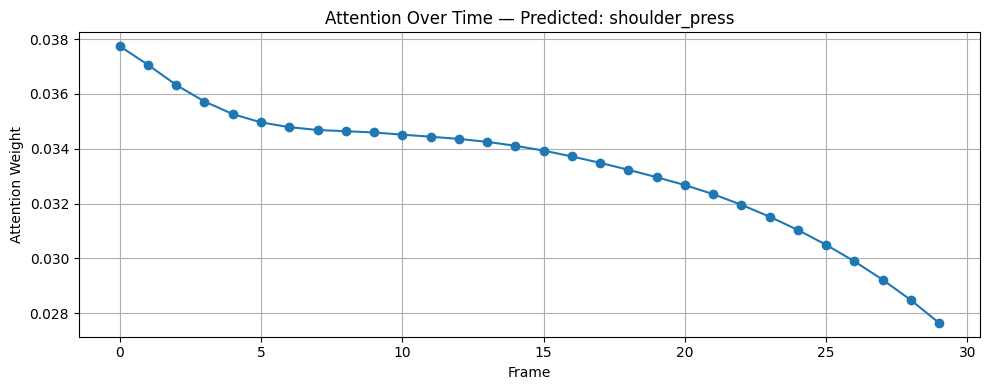

2

In [53]:
sample = X_test[35:36]  # shape: (1, 30, 78)
class_names = ['squat', 'pushup', 'shoulder_press', 'bicep_curl']  # example class names
predict_and_plot_attention(model_attn, sample, class_names=class_names)